<a href="https://colab.research.google.com/github/Kanaieu/deteksi-7-bunga-cnn/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [7 Spesies Bunga](https://www.kaggle.com/datasets/nadyana/flowers/data)
- **Nama:** Muhammad Tsaqiif Ash-Shiddiq
- **Email:** muhammadtsaqiif.ash@gmail.com
- **ID Dicoding:** muhammadtsaqiifash

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadtsaqiifa","key":"1572ef8a163b81d1b96bbe808a6d053f"}'}

In [5]:
!rm -rf flowers/

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d nadyana/flowers
!unzip flowers.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/lotus/lotusnvevin.jpg  
  inflating: flowers/lotus/louts-flower-pond-close-up-petals-stamin-lotus-lily-144696984.jpg  
  inflating: flowers/lotus/macro-lotus-flower-13214393.jpg  
  inflating: flowers/lotus/macro-pink-lotus-flower-macro-pink-lotus-flower-close-up-pink-lotus-flower-raining-sunlight-morning-159065830.jpg  
  inflating: flowers/lotus/maxresdefault1.jpg  
  inflating: flowers/lotus/micro_-shot_-of_-a_-white_-lotus_-flower_-micro_-shot_-of_-a_-white_-lotus_-flower_-with_-green_-159427226.jpg  
  inflating: flowers/lotus/national_flower_inner.jpg  
  inflating: flowers/lotus/ndsfgiw.png  
  inflating: flowers/lotus/nelumbo-nucifera-flower-also-known-as-indian-lotus-sacred-lotus-bean-india-egyptian-bean-simply-lotus-nelumbo-nucifera-143764558.jpg  
  inflating: flowers/lotus/nelumbo_2.jpg  
  inflating: flowers/lotus/nlevnwoejr.jpg  
  inflating: flowers/lotus/p9ihfe5f.png  
  inflating: flowers/lotus/pex

**Plot gambar sampel untuk semua kelas**

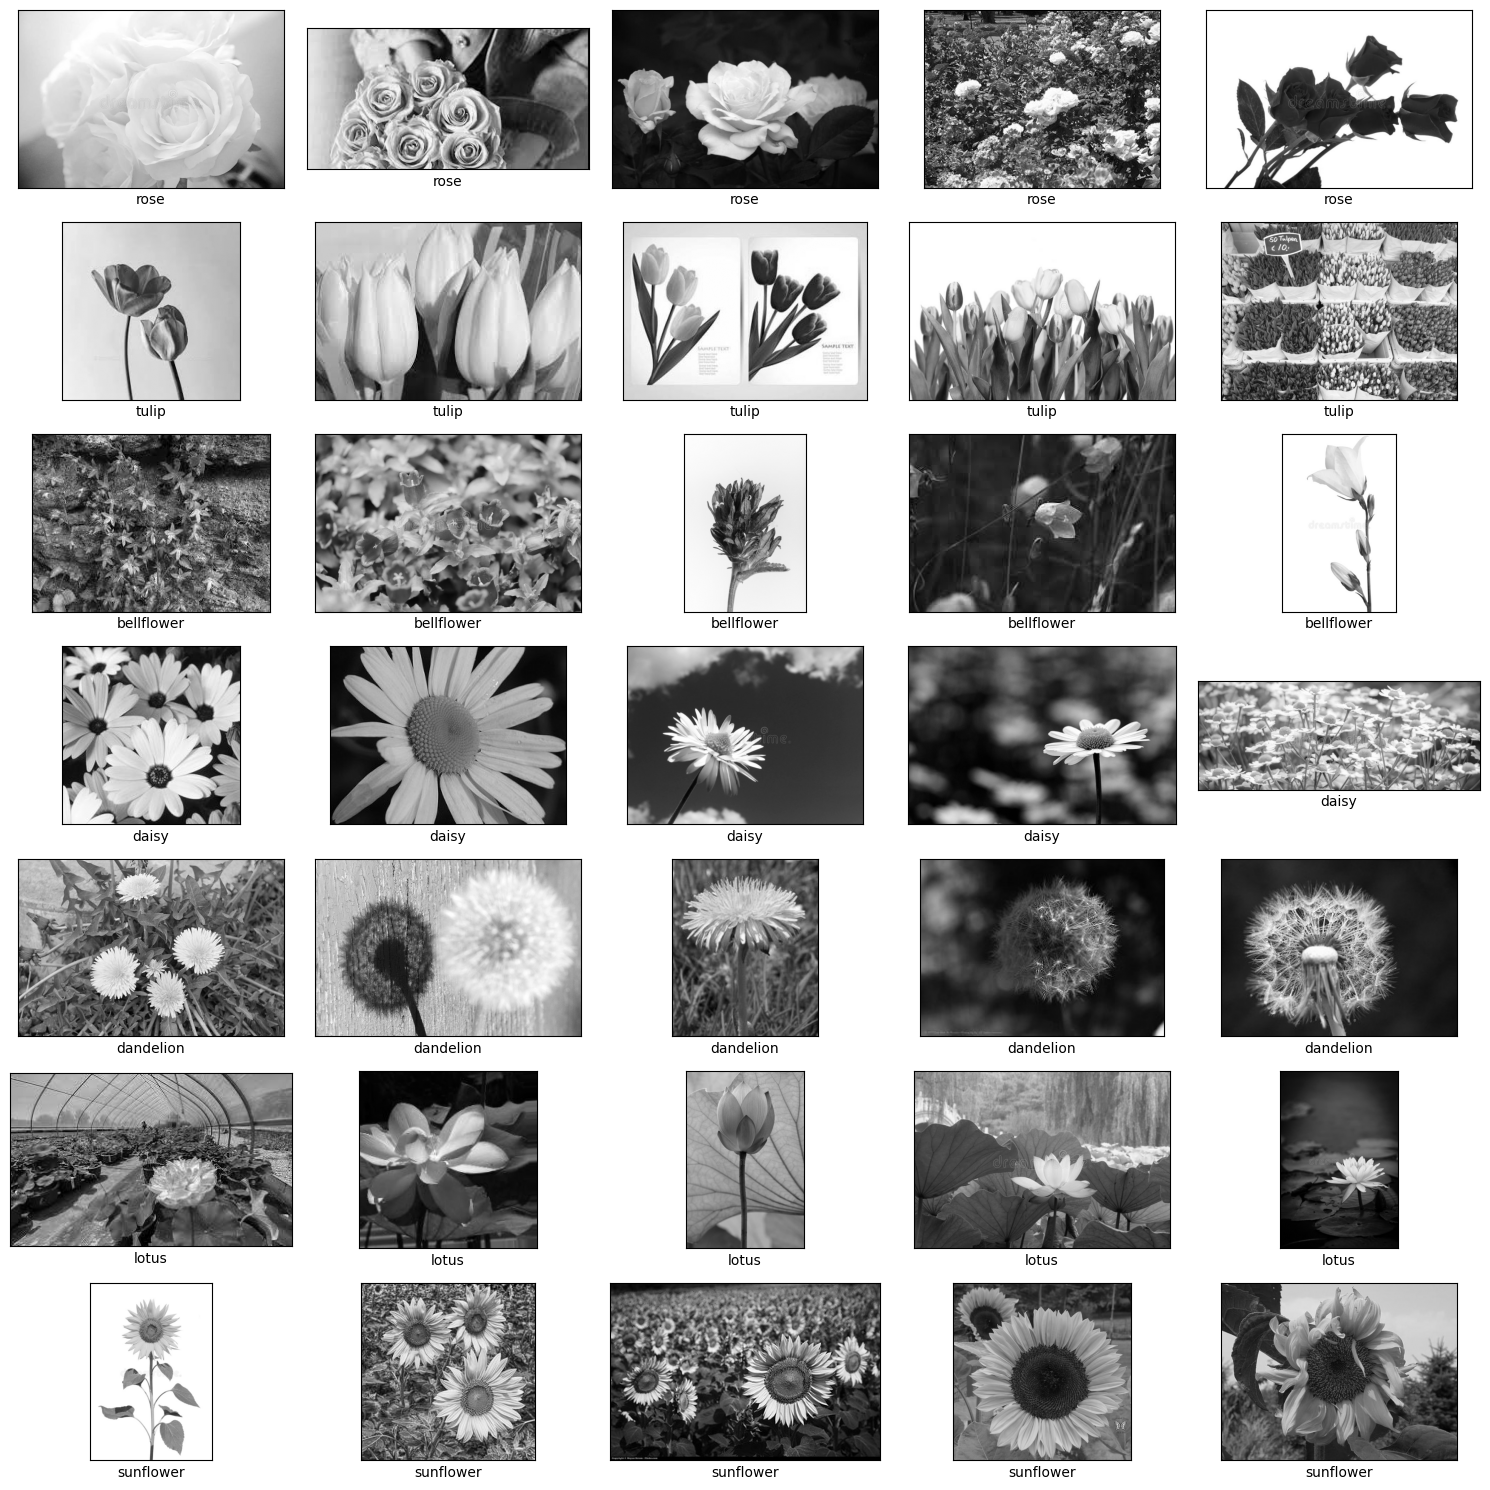

In [8]:
lung_image = {}

path = "flowers/"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Plot distribusi gambar di seluruh kelas**

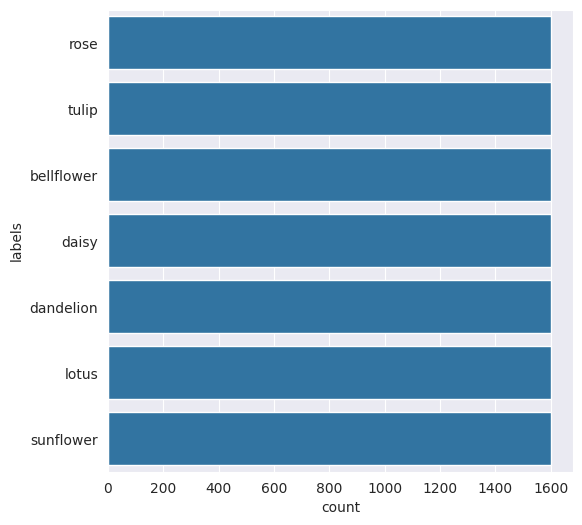

In [9]:
lung_path = "flowers/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [10]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'flowers/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
bellflower,1600
daisy,1600
dandelion,1600
lotus,1600
rose,1600
sunflower,1600
tulip,1600


In [11]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Menggunakan Stratify agar penyebaran seimbang**

In [12]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

print('train size', len(df_tr))
print('test size', len(df_te))

train size 8960
test size 2240


In [13]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels    
test   bellflower     320
       daisy          320
       dandelion      320
       lotus          320
       rose           320
       sunflower      320
       tulip          320
train  bellflower    1280
       daisy         1280
       dandelion     1280
       lotus         1280
       rose          1280
       sunflower     1280
       tulip         1280
dtype: int64 


                                                path      labels    set
7129        flowers/tulip/14067778605_0285b7cc3a.jpg       tulip  train
3272               flowers/bellflower/268d396203.jpg  bellflower  train
3318  flowers/bellflower/bellflower-buds-4063314.jpg  bellflower  train
1547       flowers/daisy/7227973870_806d9d3e42_n.jpg       daisy  train
4264                     flowers/rose/30dbeab724.jpg        rose  train


In [14]:
datasource_path = "flowers/"
dataset_path = "Dataset-Final/"

In [15]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Image Data Generator

In [16]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_bellflower = os.path.join(TRAIN_DIR, 'bellflower')
train_daisy = os.path.join(TRAIN_DIR, 'daisy')
train_dandelion = os.path.join(TRAIN_DIR, 'dandelion')
train_lotus = os.path.join(TRAIN_DIR, 'lotus')
train_rose = os.path.join(TRAIN_DIR, 'rose')
train_sunflower = os.path.join(TRAIN_DIR, 'sunflower')
train_tulip = os.path.join(TRAIN_DIR, 'tulip')

test_bellflower = os.path.join(TEST_DIR, 'bellflower')
test_daisy = os.path.join(TEST_DIR, 'daisy')
test_dandelion = os.path.join(TEST_DIR, 'dandelion')
test_lotus = os.path.join(TEST_DIR, 'lotus')
test_rose = os.path.join(TEST_DIR, 'rose')
test_sunflower = os.path.join(TEST_DIR, 'sunflower')
test_tulip = os.path.join(TEST_DIR, 'tulip')

print("Total number of bellflower images in training set: ", len(os.listdir(train_bellflower)))
print("Total number of daisy images in training set: ", len(os.listdir(train_daisy)))
print("Total number of dandelion images in training set: ", len(os.listdir(train_dandelion)))
print("Total number of lotus images in training set: ", len(os.listdir(train_lotus)))
print("Total number of rose images in training set: ", len(os.listdir(train_rose)))
print("Total number of sunflower images in training set: ", len(os.listdir(train_sunflower)))
print("Total number of tulips images in training set: ", len(os.listdir(train_tulip)))

print("Total number of bellflower images in test set: ", len(os.listdir(test_bellflower)))
print("Total number of daisy images in test set: ", len(os.listdir(test_daisy)))
print("Total number of dandelion images in test set: ", len(os.listdir(test_dandelion)))
print("Total number of lotus images in test set: ", len(os.listdir(test_lotus)))
print("Total number of rose images in test set: ", len(os.listdir(test_rose)))
print("Total number of sunflower images in test set: ", len(os.listdir(test_sunflower)))
print("Total number of tulips images in test set: ", len(os.listdir(test_tulip)))

Total number of bellflower images in training set:  1280
Total number of daisy images in training set:  1280
Total number of dandelion images in training set:  1280
Total number of lotus images in training set:  1280
Total number of rose images in training set:  1280
Total number of sunflower images in training set:  1280
Total number of tulips images in training set:  1280
Total number of bellflower images in test set:  320
Total number of daisy images in test set:  320
Total number of dandelion images in test set:  320
Total number of lotus images in test set:  320
Total number of rose images in test set:  320
Total number of sunflower images in test set:  320
Total number of tulips images in test set:  320


In [53]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=16,
    subset='training',
    class_mode='sparse',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=16,
    subset='validation',
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode='sparse',
    subset=None,
    shuffle=False
)

Found 7168 images belonging to 7 classes.
Found 1792 images belonging to 7 classes.
Found 2240 images belonging to 7 classes.


## Modelling

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

In [54]:
from tensorflow.keras import regularizers
model_32 = Sequential([
    # 1st Convolutional Block
    # Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.0005))
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(32, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(32, (7, 7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Flatten layer
    Flatten(),

    # Dense + Dropout layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.4),

    # Output layer
    Dense(7, activation='softmax')
])

In [55]:
model_32.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [21]:
print(model_32.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,847 (5.36 MB)

 Trainable params: 1,403,655 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [22]:
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', target=0.85, patience=5):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.monitor = monitor
        self.target = target
        self.patience = patience
        self.wait = 0
        self.stopping_triggered = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)

        if current is None:
            return

        if current >= self.target:
            if not self.stopping_triggered:
                self.stopping_triggered = True
                self.wait = 0

            else:
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\nStopping training: {self.monitor} sudah >= {self.target} dan patience {self.patience} habis.")
                self.wait += 1
        else:
            self.wait = 0

In [23]:
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_accuracy = EarlyStoppingAtAccuracy(monitor='val_accuracy', target=0.85, patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_lr=1e-6)

In [56]:
history_32 = model_32.fit(
    train_generator,
    epochs=40,
    batch_size=16,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_accuracy, reduce_lr]
)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2747 - loss: 2.3324
Epoch 1: val_accuracy did not improve from 0.82924
448/448 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.2747 - loss: 2.3318 - val_accuracy: 0.4185 - val_loss: 1.6245 - learning_rate: 1.0000e-04
Epoch 2/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3884 - loss: 1.7257
Epoch 2: val_accuracy did not improve from 0.82924
448/448 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.3884 - loss: 1.7257 - val_accuracy: 0.5223 - val_loss: 1.2874 - learning_rate: 1.0000e-04
Epoch 3/40
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4633 - loss: 1.5611
Epoch 3: val_accuracy did not improve from 0.82924
448/448 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.4633 - loss: 1.5611 - val_accuracy: 0.5463 - val_loss: 1.2619 - learning_rate: 1.0000e-04
Epoch 4/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4825 - loss: 1.4478
Epoch 4: val_accuracy did not improve from 0.82924
448/448 ━━━━━━━━━━

## Evaluasi dan Visualisasi

In [ ]:
acc = history_32.history['accuracy']
val_acc = history_32.history['val_accuracy']
loss = history_32.history['loss']
val_loss = history_32.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_1 = model_32.predict(test_generator, verbose=0)
preds_1 = np.argmax(preds_1, axis=1)
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1),
                  index=["Actual Bellflower", "Actual Daisy", "Actual Dandelion", "Actual Lotus", "Actual Rose", "Actual Sunflower", "Actual Tulips"],
                  columns=["Predicted Bellflower", "Predicted Daisy", "Predicted Dandelion", "Predicted Lotus", "Predicted Rose", "Predicted Sunflower", "Predicted Tulips"])

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=preds_1,
                            target_names=['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulips'],
                            digits=4))

## Konversi Model

**savedmodel**

In [ ]:
model_32.save("/content/saved_model")

**TensorFlow Lite**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_32)
tflite_model = converter.convert()

with open("/content/tflite/model_32.tflite", "wb") as f:
    f.write(tflite_model)

**TensorFlow.js**

In [ ]:
tfjs.converters.save_keras_model(model_32, "/content/tfjs_model")

## Inference (Optional)

In [ ]:
model_path = '/content/saved_model'
model = tf.keras.models.load_model(model_path)

In [ ]:
img_path = 'flowers/bellflower/0.jpg'
img = tf.keras.preprocessing.image.load_img(img_path)
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array_resized = resize_with_padding(img_array, 150, 150)
img_array_resized = img_array_resized / 255.0

img_array_resized = tf.expand_dims(img_array_resized, axis=0)

predictions = model_1.predict(img_array_resized)
print(predictions)